In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
!pip install Keras-Preprocessing
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Resizing
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D, AveragePooling2D
from keras.regularizers import l2
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
!pip install keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras import backend as keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.densenet import DenseNet201, DenseNet121
from keras.applications import EfficientNetV2S, EfficientNetV2B1
from keras.utils.vis_utils import plot_model
# from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import cv2
import skimage.io as io
import skimage.transform as trans
import glob
from PIL import Image
import skimage
from keras.initializers import Constant

from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from skimage.measure import label, regionprops
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import jaccard_score

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
import zipfile
import random
import sys

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import binary_crossentropy
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt
from keras.layers import Concatenate, add

import warnings
warnings.filterwarnings("ignore")
random.seed(42)
from keras.losses import binary_crossentropy
from sklearn.metrics import precision_recall_curve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/IOSTAR_Augmented'
os.listdir(dataset_dir)

['test', 'train aug']

In [ ]:

def dice_coef(y_true, y_pred,smooth = 10):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def Jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def Jaccard_coef_loss(y_true, y_pred):
    return (1-Jaccard_coef(y_true, y_pred))

# def bcc_Jaccard_coef_loss(y_true, y_pred):
#     return (binary_crossentropy(y_true, y_pred)+(1-Jaccard_coef(y_true, y_pred)))

#Metricess

def iou(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coef(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

def sensitivity(y_train, results):
    true_positives = K.sum(K.round(K.clip(y_train * results, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
    sensitivity = true_positives / (actual_positives + K.epsilon())
    return sensitivity

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

def DiceLoss(y_true, y_pred, smooth=1e-6):
    y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
    nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
    denominator = tf.reduce_sum(y_pred ** 2) + tf.reduce_sum(y_true ** 2) + smooth
    result = 1 - tf.divide(nominator, denominator)
    return result


def bcc_Jaccard_coef_loss(y_true, y_pred):
    return (DiceLoss(y_true, y_pred, smooth=1e-6)+(1-iou(y_true, y_pred, threshold=0.5)))
    #return (DiceLoss(y_true, y_pred, smooth=1e-6)+(1-iou(y_true, y_pred, threshold=0.5))+ (0.01*surface_loss_keras(y_true, y_pred)))

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate
from keras import backend as K

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])


In [ ]:
def create_transfuse_net(input_shape):
    # Define the input layer
    inputs = layers.Input(shape=input_shape)

    # Encoder - Convolutional Blocks
    conv_block1 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_block1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block1)
    conv_block1 = layers.BatchNormalization()(conv_block1)

    conv_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(conv_block1)
    conv_block2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block2)
    conv_block2 = layers.BatchNormalization()(conv_block2)

    conv_block3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv_block2)
    conv_block3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block3)
    conv_block3 = layers.BatchNormalization()(conv_block3)

    # Encoder - Transformer Block
    transformer_block = layers.Reshape((-1, conv_block3.shape[3]))(conv_block3)
    transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=32)(transformer_block, transformer_block)
    transformer_block = layers.GlobalAveragePooling1D()(transformer_block)
    transformer_block = layers.Reshape((1, 1, transformer_block.shape[1]))(transformer_block)

    # Tile the transformer block output to match the spatial dimensions of the convolutional block
    transformer_block = layers.Lambda(lambda x: tf.tile(x, [1, conv_block3.shape[1], conv_block3.shape[2], 1]))(transformer_block)

    # Concatenate the Encoder Convolutional and Transformer blocks

    att1 = cbam_block(transformer_block)
    fused_features = layers.Concatenate()([conv_block3, att1])

    # Decoder - Upsampling Blocks
    decoder_block1 = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(fused_features)
    att2=cbam_block(decoder_block1)
    decoder_block1 = layers.Concatenate()([att2, conv_block2])
    decoder_block1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block1)

    decoder_block2 = layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block1)

    att3=cbam_block(decoder_block2)
    decoder_block2 = layers.Concatenate()([att3, conv_block1])
    decoder_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block2)


    decoder_block3 = layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block2)
    decoder_block3 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(decoder_block3)
    # Decoder - Output Block
    output_BV = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid',name = 'final_output1')(decoder_block3)
    output_OD = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name = 'final_output2')(decoder_block3)

    # Create the model
    model = models.Model(inputs=inputs, outputs=[output_BV, output_OD])

    return model

# Define the input shape for binary semantic segmentation
input_shape = (512,512,3)  # Example input shape for RGB images

# Create the TransFuse Encoder-Decoder model with 3 MaxPooling layers for binary semantic segmentation
model = create_transfuse_net(input_shape)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'final_output1': bcc_Jaccard_coef_loss, 'final_output2': bcc_Jaccard_coef_loss},
              metrics={'final_output1': [dice_coef, iou, sensitivity, specificity],
                       'final_output2': [dice_coef, iou, sensitivity, specificity]})

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  224         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['max_pooling2d[0][0]']      

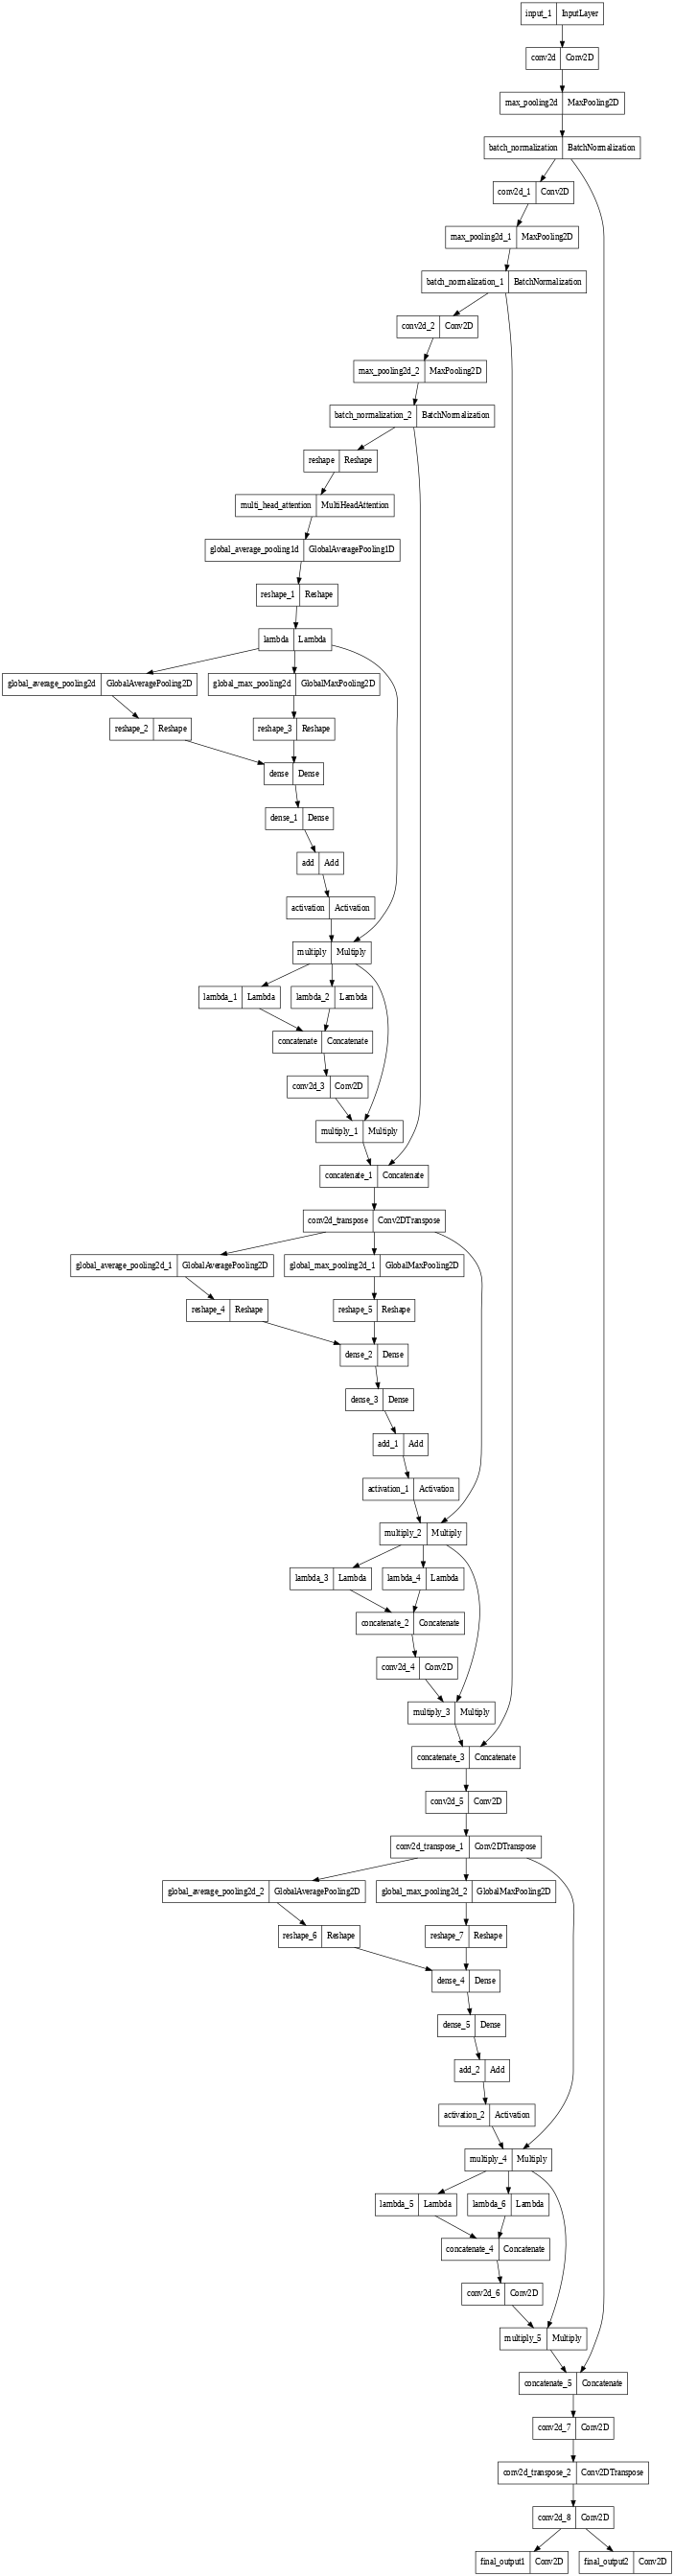

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
    layer_range=None
)

In [ ]:
train_data ='/content/drive/MyDrive/Colab_Notebooks/IOSTAR_Augmented/train aug' #data path
valid_data = '/content/drive/MyDrive/Colab_Notebooks/IOSTAR_Augmented/test'

In [ ]:

import os
import numpy as np
im_height=512
im_width=512
# Get and resize train images and masks
def get_data(path):
    images_paths = os.path.join(path,'images')
    masks_path_BV = os.path.join(path,'GT_BV')
    masks_path_OD = os.path.join(path,'GT_OD')

    # images_ids = os.listdir(images_paths)
    # masks_ids = os.listdir(masks_paths)
    images_ids = sorted(os.listdir(images_paths))
    mask1_ids = sorted(os.listdir(masks_path_BV))
    mask2_ids = sorted(os.listdir(masks_path_OD))

    X = np.zeros((len(images_ids), im_height, im_width, 3), dtype=np.float32)
    y1 = np.zeros((len(mask1_ids), im_height, im_width, 1), dtype=np.float32)
    y2 = np.zeros((len(mask2_ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n in range (len(images_ids)):
        # Load images
        img = img_to_array(load_img(os.path.join(images_paths,images_ids[n]), grayscale=False))
        x_img = resize(img, (im_height, im_width, 3), mode='constant', preserve_range=True)

        # Load masks
        mask_BV = img_to_array(load_img(os.path.join(masks_path_BV,mask1_ids[n]), grayscale=True))
        mask_BV = resize( mask_BV, (im_height, im_width, 1), mode='constant', preserve_range=True)

        mask_OD = img_to_array(load_img(os.path.join(masks_path_OD, mask2_ids[n]), grayscale=True))
        mask_OD = resize(mask_OD, (im_height, im_width, 1), mode='constant', preserve_range=True)
        # Save images
        X[n] = x_img/ 255
        y1[n] = mask_BV/ 255
        y2[n] = mask_OD/255

    print('Done!')
    return X, [y1,y2]


In [ ]:
X, [y1, y2] = get_data(train_data)  # get_data returns the input data and two output data sets

from sklearn.model_selection import train_test_split

# Split data for the BV task
X_train, X_test, y1_train_BV, y1_test_BV = train_test_split(X, y1, test_size=0.2, random_state=42)

# Split data for the OD task. Note: We use the same X_train and X_test for this task as well.
X_train, X_test, y2_train_od, y2_test_od = train_test_split(X, y2, test_size=0.2, random_state=42)


Getting and resizing images ... 
Done!


In [ ]:
nb_epoch = 300
batch_size=8
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab_Folder/Model Weights/IOSTAR/checkpoints/MTLTransfuseep300bs8.h5', verbose=1, save_best_only=True,save_weights_only=True)
callbacks = [checkpoint]

In [ ]:
results = model.fit(X_train,[y1_train_BV,y2_train_od], batch_size=batch_size, epochs=nb_epoch, callbacks=callbacks,validation_data=([X_test,[y1_test_BV,y2_test_od]]))


Epoch 1/300
36/36 [==============================] - ETA: 0s - loss: 3.5400 - final_output1_loss: 1.6970 - final_output2_loss: 1.8430 - final_output1_dice_coef: 0.0566 - final_output1_iou: 0.0302 - final_output1_sensitivity: 0.0964 - final_output1_specificity: 0.8196 - final_output2_dice_coef: 0.0161 - final_output2_iou: 0.0083 - final_output2_sensitivity: 0.0262 - final_output2_specificity: 0.9852
Epoch 1: val_loss improved from inf to 3.64488, saving model to /content/drive/MyDrive/Colab_Folder/Model Weights/IOSTAR/checkpoints/MTLTransfuseep300bs8.h5
36/36 [==============================] - 31s 206ms/step - loss: 3.5400 - final_output1_loss: 1.6970 - final_output2_loss: 1.8430 - final_output1_dice_coef: 0.0566 - final_output1_iou: 0.0302 - final_output1_sensitivity: 0.0964 - final_output1_specificity: 0.8196 - final_output2_dice_coef: 0.0161 - final_output2_iou: 0.0083 - final_output2_sensitivity: 0.0262 - final_output2_specificity: 0.9852 - val_loss: 3.6449 - val_final_output1_loss:

In [ ]:
def evaluate_metrics(y_test, y_pred):
  n = y_pred.shape[0]
  all_F1_score = np.zeros(n)
  all_dice = np.zeros(n)
  all_jaccard = np.zeros(n)
  all_sensitivity = np.zeros(n)
  all_specificity = np.zeros(n)
  for i in range(n):
      gt, pred = y_test[i], y_pred[i]
      gt_flt = np.ndarray.flatten(gt)
      pred_flt = np.ndarray.flatten(pred)

      precisions, recalls, thresholds = precision_recall_curve(gt_flt, pred_flt)
      f1 = 2*(precisions * recalls) / (precisions + recalls)
      max_value = np.argmax(f1)
      thres = thresholds[max_value]
      pred_mask = (pred_flt >= thres)
      pred_label = pred_mask*1

      tn, fp, fn, tp = confusion_matrix(gt_flt, pred_label).ravel()

      F1_score = tp/(tp+((0.5)*(fp+fn)))
      iou = tp / (tp + fp + fn)
      dice = 2*tp / (2*tp + fp + fn)
      specificity = tn / (tn + fp)
      recall = tp / (tp + fn)

      all_F1_score[i] = F1_score
      all_dice[i] = dice
      all_jaccard[i] = iou
      all_sensitivity[i] = recall
      all_specificity[i] = specificity

  print(' F1_score: {:4f}, Dice: {:4f}, Jaccard: {:4f}, Sensitivity: {:4f}, Specificity: {:4f}'.format(
        np.nanmean(all_F1_score), np.nanmean(all_dice), np.nanmean(all_jaccard), np.nanmean(all_sensitivity), np.nanmean(all_specificity)
  ))
  return all_F1_score, all_dice, all_jaccard, all_sensitivity, all_specificity


In [ ]:
model.save_weights('/content/drive/MyDrive/Colab_Folder/Model Weights/IOSTAR/checkpoints/MTLTransfuseep300bs8.h5')

In [ ]:
# valid_data = '/content/ISIC2018_256x256/test' #data path
X_test, y_test = get_data(valid_data)

Getting and resizing images ... 
Done!


In [ ]:
# Convert ground truth labels to binary
y_test_BV = (y_test[0] > 0.5).astype(np.uint8)
y_test_OD = (y_test[1] > 0.5).astype(np.uint8)

start_time = time.time()
predictions = model.predict(X_test, verbose=1)
end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {:.2f} seconds".format(inference_time))
inference_time_per_image = inference_time/len(X_test)
print("Inference Time per image: {:.2f} seconds".format(inference_time_per_image ))


1/1 [==============================] - 1s 1s/step
Inference Time: 1.40 seconds
Inference Time per image: 0.14 seconds


In [ ]:
# Convert model's outputs to binary
predictions_BV = (predictions[0] > 0.5).astype(np.uint8)
predictions_OD = (predictions[1] > 0.5).astype(np.uint8)

# Evaluate metrics for each task
eval_BV = evaluate_metrics(y_test_BV, predictions_BV)
eval_OD = evaluate_metrics(y_test_OD, predictions_OD)

 F1_score: 0.786122, Dice: 0.786122, Jaccard: 0.648603, Sensitivity: 0.791773, Specificity: 0.982449
 F1_score: 0.837272, Dice: 0.837272, Jaccard: 0.722692, Sensitivity: 0.786249, Specificity: 0.997884


In [ ]:
test_image = load_img('/content/drive/MyDrive/Colab_Notebooks/IOSTAR_Augmented/test/images/28.jpg', target_size=(512, 512))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)
# Scale the pixel values to [0, 1] range
test_image = test_image / 255.

# Use the model to predict the mask for the test image

start_time = time.time()
preds_test = model.predict(test_image)
end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {:.2f} seconds".format(inference_time))


(1, 512, 512, 3)
1/1 [==============================] - 0s 320ms/step
Inference Time: 0.36 seconds


(-0.5, 511.5, 511.5, -0.5)

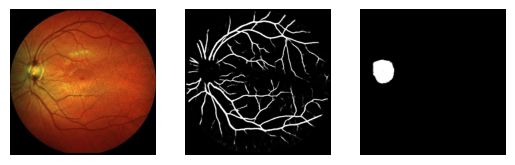

In [ ]:
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow((test_image[0]))
ax[0].axis('off')
ax[1].imshow(np.squeeze(preds_test[0]), cmap='gray') # squeeze out unnecessary dimensions
ax[1].axis('off')
ax[2].imshow(np.squeeze(preds_test[1]), cmap='gray')
ax[2].axis('off')

#fig, ax = plt.subplots(nrows=1, ncols=2)
#ax[0].imshow(test_image[0])
#ax[1].imshow(preds_test[0], cmap='gray') # you may need

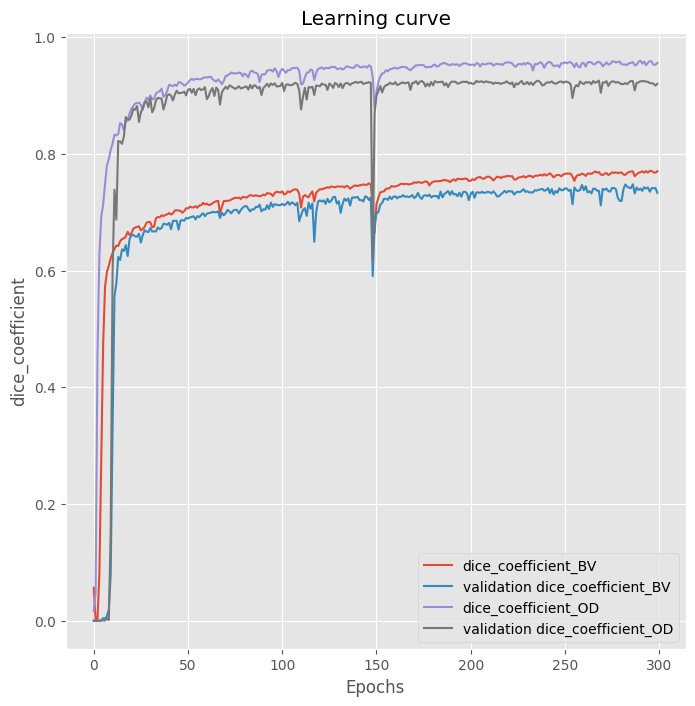

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["final_output1_dice_coef"], label="dice_coefficient_BV")
plt.plot(results.history["val_final_output1_dice_coef"], label="validation dice_coefficient_BV")
plt.plot(results.history["final_output2_dice_coef"], label="dice_coefficient_OD")
plt.plot(results.history["val_final_output2_dice_coef"], label="validation dice_coefficient_OD")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coefficient")
plt.legend();

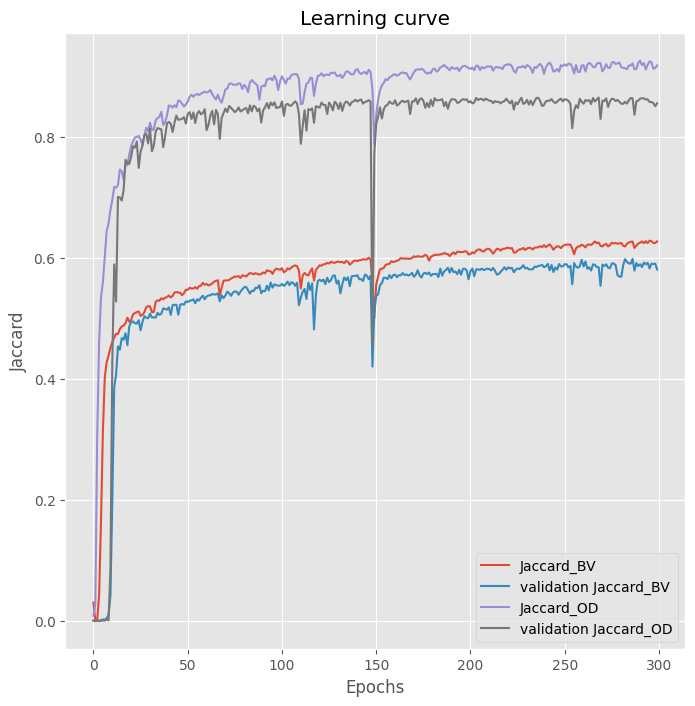

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["final_output1_iou"], label="Jaccard_BV")
plt.plot(results.history["val_final_output1_iou"], label="validation Jaccard_BV")
plt.plot(results.history["final_output2_iou"], label="Jaccard_OD")
plt.plot(results.history["val_final_output2_iou"], label="validation Jaccard_OD")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Jaccard")
plt.legend();

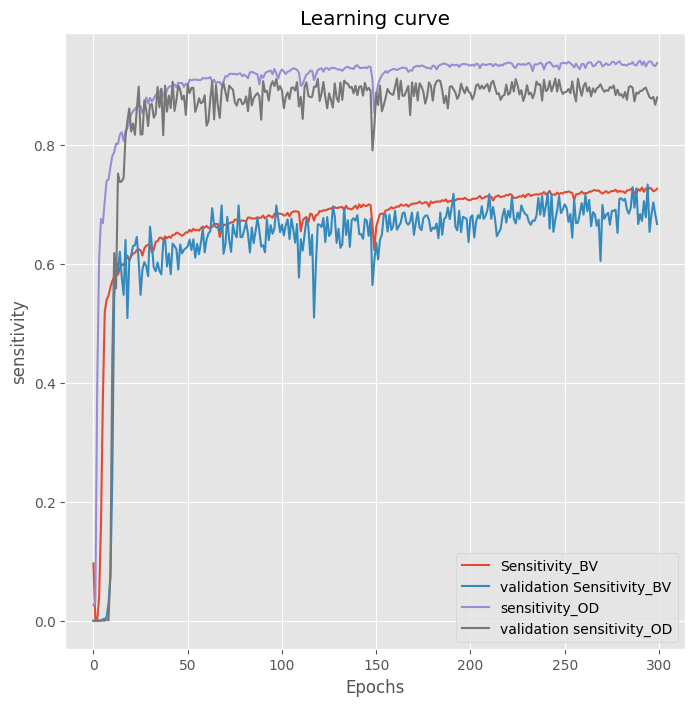

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["final_output1_sensitivity"], label="Sensitivity_BV")
plt.plot(results.history["val_final_output1_sensitivity"], label="validation Sensitivity_BV")
plt.plot(results.history["final_output2_sensitivity"], label="sensitivity_OD")
plt.plot(results.history["val_final_output2_sensitivity"], label="validation sensitivity_OD")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("sensitivity")
plt.legend();

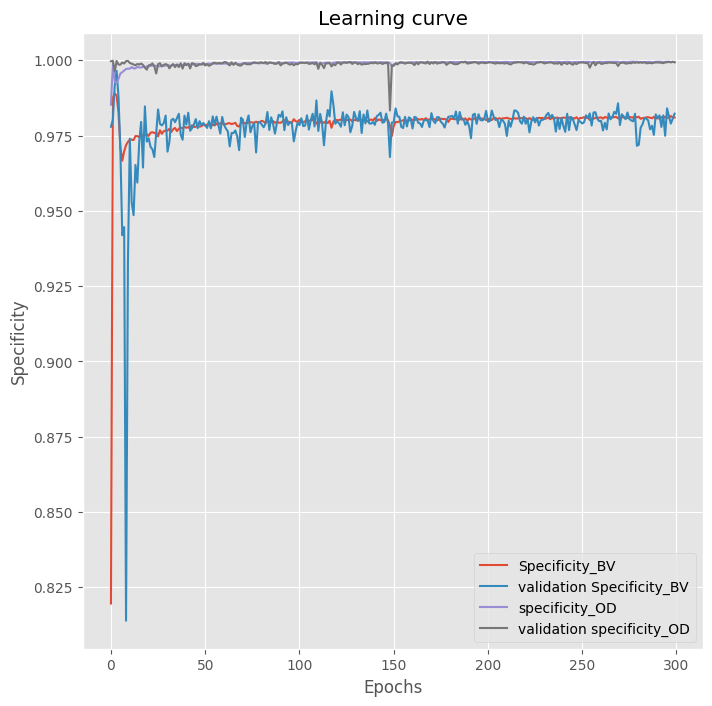

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["final_output1_specificity"], label="Specificity_BV")
plt.plot(results.history["val_final_output1_specificity"], label="validation Specificity_BV")
plt.plot(results.history["final_output2_specificity"], label="specificity_OD")
plt.plot(results.history["val_final_output2_specificity"], label="validation specificity_OD")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Specificity")
plt.legend();

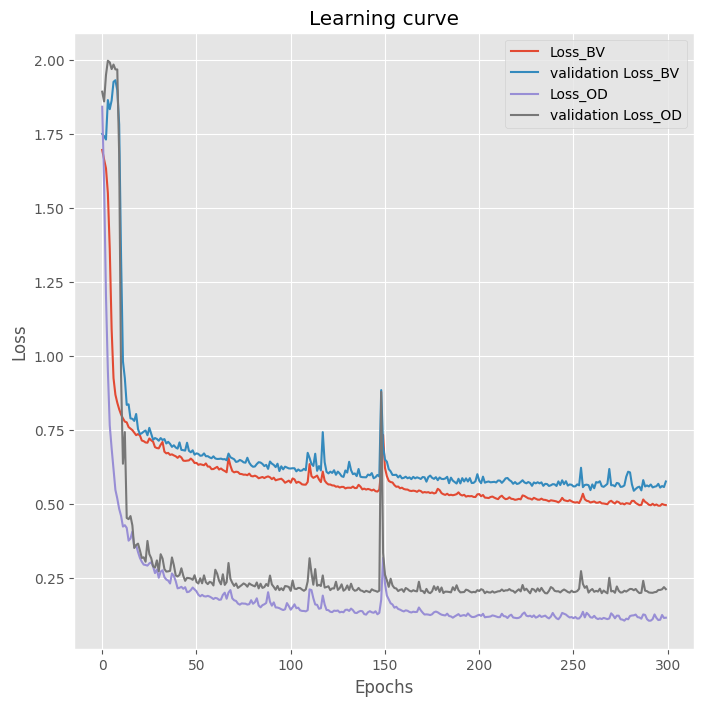

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["final_output1_loss"], label="Loss_BV")
plt.plot(results.history["val_final_output1_loss"], label="validation Loss_BV")
plt.plot(results.history["final_output2_loss"], label="Loss_OD")
plt.plot(results.history["val_final_output2_loss"], label="validation Loss_OD")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [ ]:
memory_usage = model.count_params() * 4  # Assuming float32 data type (4 bytes per parameter)
print("Memory Usage: {:.2f} MB".format(memory_usage / 1024 / 1024))  # Divide by 1024 twice to convert from bytes to KB, then KB to MB


Memory Usage: 0.25 MB


In [ ]:
  !pip install keras-flops
  from keras_flops import get_flops

  flops = get_flops(model)
  print(f"FLOPs: {flops / 10**9:.03} G")

FLOPs: 2.47 G
